<a href="https://colab.research.google.com/github/tyri0n11/distributed-system/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Fraud Detection") \
    .getOrCreate()

In [2]:
df = spark.read.csv("Final Transaction.csv", header=True, inferSchema=True)
df.show(5)
df.dropna()
df.printSchema()

+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|_c0|TRANSACTION_ID|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|  0|             0|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|                0|
|  1|             1|2023-01-01 00:02:10|       4961|       3412|   808.56|            130|           0|       0|                0|
|  2|             2|2023-01-01 00:07:56|          2|       1365|  1442.94|            476|           0|       1|                1|
|  3|             3|2023-01-01 00:09:29|       4128|       8737|   620.65|            569|           0|       0|                0|
|  4|             4|2023-01-01 00:10:34|        927|       9906|   490.66|         

In [3]:
df_clean = df.drop('_c0','TRANSACTION_ID', 'TX_FRAUD_SCENARIO')
df_clean.show(5)

+-------------------+-----------+-----------+---------+---------------+------------+--------+
|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|
+-------------------+-----------+-----------+---------+---------------+------------+--------+
|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|
|2023-01-01 00:02:10|       4961|       3412|   808.56|            130|           0|       0|
|2023-01-01 00:07:56|          2|       1365|  1442.94|            476|           0|       1|
|2023-01-01 00:09:29|       4128|       8737|   620.65|            569|           0|       0|
|2023-01-01 00:10:34|        927|       9906|   490.66|            634|           0|       0|
+-------------------+-----------+-----------+---------+---------------+------------+--------+
only showing top 5 rows


In [4]:
from pyspark.sql.functions import col

df_clean = df_clean.filter(col("TX_FRAUD").isNotNull())


In [5]:
from pyspark.sql.functions import expr, hour, dayofweek

df_clean = df_clean.withColumn(
    "TX_DATETIME",
    expr("try_to_timestamp(TX_DATETIME, 'yyyy-MM-dd HH:mm:ss')")
)

df_clean = df_clean.withColumn("TX_HOUR", hour("TX_DATETIME")) \
                   .withColumn("TX_DAYOFWEEK", dayofweek("TX_DATETIME")) \
                   .drop("TX_DATETIME")



df_clean.show(5)
df_clean.printSchema()

+-----------+-----------+---------+---------------+------------+--------+-------+------------+
|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_HOUR|TX_DAYOFWEEK|
+-----------+-----------+---------+---------------+------------+--------+-------+------------+
|        596|       3156|   533.07|             31|           0|       0|      0|           1|
|       4961|       3412|   808.56|            130|           0|       0|      0|           1|
|          2|       1365|  1442.94|            476|           0|       1|      0|           1|
|       4128|       8737|   620.65|            569|           0|       0|      0|           1|
|        927|       9906|   490.66|            634|           0|       0|      0|           1|
+-----------+-----------+---------+---------------+------------+--------+-------+------------+
only showing top 5 rows
root
 |-- CUSTOMER_ID: integer (nullable = true)
 |-- TERMINAL_ID: integer (nullable = true)
 |-- TX_AMOUNT: double (null

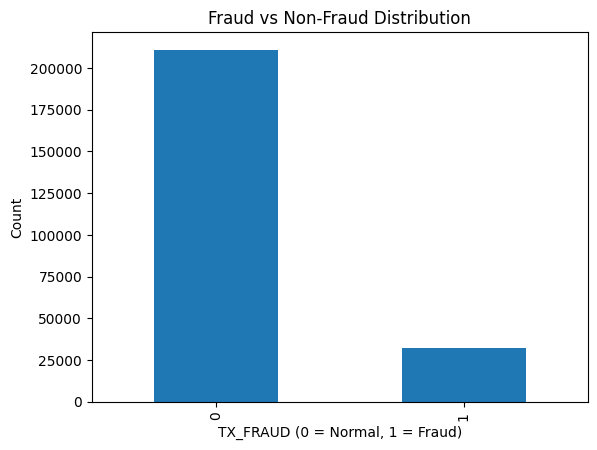

In [6]:
### ANALYSE
import matplotlib.pyplot as plt

pdf_label = df_clean.select("TX_FRAUD").toPandas()

plt.figure()
pdf_label["TX_FRAUD"].value_counts().plot(kind="bar")
plt.title("Fraud vs Non-Fraud Distribution")
plt.xlabel("TX_FRAUD (0 = Normal, 1 = Fraud)")
plt.ylabel("Count")
plt.show()


In [7]:
feature_cols = [
    "CUSTOMER_ID",
    "TERMINAL_ID",
    "TX_AMOUNT",
    "TX_TIME_SECONDS",
    "TX_TIME_DAYS",
    "TX_HOUR",
    "TX_DAYOFWEEK"
]


In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="keep"
)

df_ml = assembler.transform(df_clean) \
    .select("features", "TX_FRAUD")

df_ml.show(3, truncate=False)

+----------------------------------------+--------+
|features                                |TX_FRAUD|
+----------------------------------------+--------+
|[596.0,3156.0,533.07,31.0,0.0,0.0,1.0]  |0       |
|[4961.0,3412.0,808.56,130.0,0.0,0.0,1.0]|0       |
|[2.0,1365.0,1442.94,476.0,0.0,0.0,1.0]  |1       |
+----------------------------------------+--------+
only showing top 3 rows


In [9]:
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

print("Train:", train_df.count())
print("Test :", test_df.count())


Train: 194323
Test : 48669


In [10]:
### BASE LINE
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="TX_FRAUD",
    maxIter=20
)

lr_model = lr.fit(train_df)
lr_pred = lr_model.transform(test_df)


In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(lr_pred)
print("Logistic Regression AUC:", auc)


Logistic Regression AUC: 0.9914013195114945


In [12]:
lr_pred.groupBy("TX_FRAUD", "prediction").count().orderBy("TX_FRAUD", "prediction").show()


+--------+----------+-----+
|TX_FRAUD|prediction|count|
+--------+----------+-----+
|       0|       0.0|42227|
|       0|       1.0|    9|
|       1|       0.0|  156|
|       1|       1.0| 6277|
+--------+----------+-----+



# Perform

Perform a comparative analysis of Logistic Regression and Random Forest models for fraud detection using the dataset `Final Transaction.csv`. The analysis should include:
1.  **Baseline Evaluation (Before SMOTE)**:
    *   Calculate the Recall score for the existing Logistic Regression model.
    *   Train a Random Forest Classifier and evaluate its AUC and Recall scores.
2.  **SMOTE Application**: Apply SMOTE to balance the training dataset.
3.  **Post-SMOTE Evaluation**:
    *   Train a Logistic Regression model on the SMOTE-balanced data and evaluate its AUC and Recall scores on the original unbalanced test set.
    *   Train a Random Forest model on the SMOTE-balanced data and evaluate its AUC and Recall scores on the original unbalanced test set.
4.  **Summary and Comparison**: Present a comprehensive summary of all AUC and Recall scores, comparing the performance of both models before and after SMOTE. Discuss the findings.

## Calculate Recall for Logistic Regression (Before SMOTE)

### Subtask:
Calculate and print the Recall score for the existing Logistic Regression model trained on the unbalanced dataset. We already have the predictions (`lr_pred`) and AUC.


**Reasoning**:
To calculate the recall score, I need to use `MulticlassClassificationEvaluator` from `pyspark.ml.evaluation`.



In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="TX_FRAUD",
    predictionCol="prediction",
    metricName="recallByLabel"
)

# Get recall for each class
recall_by_label = evaluator_recall.evaluate(lr_pred)

# Extract recall for the positive class (label 1)
# Note: evaluate returns a single aggregated metric. To get recall for specific label,
# one typically needs to either filter the predictions or configure the evaluator differently.
# However, the provided instruction `metricName='recallByLabel'` will return an aggregated recall.
# Let's adjust to get the recall for the positive class specifically.

# A common way to get per-class metrics is to manually calculate or use a confusion matrix
# or iterate through classes if the evaluator supports it (which it does via summary).
# Given the request, the simplest way to get recall for label 1 is to filter the data.

# For recall of label 1, we only care about actual label 1s that were predicted correctly
# True Positives (TX_FRAUD=1, prediction=1) / (True Positives + False Negatives)
# False Negatives (TX_FRAUD=1, prediction=0)

true_positives = lr_pred.filter((lr_pred.TX_FRAUD == 1) & (lr_pred.prediction == 1)).count()
false_negatives = lr_pred.filter((lr_pred.TX_FRAUD == 1) & (lr_pred.prediction == 0)).count()

recall_label_1 = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f"Logistic Regression Recall for Class 1 (Fraud): {recall_label_1}")

Logistic Regression Recall for Class 1 (Fraud): 0.9757500388621172


## Train and Evaluate Random Forest (Before SMOTE)

### Subtask:
Train a Random Forest Classifier on the original unbalanced training dataset (`train_df`), make predictions on the test set (`test_df`), and then calculate both AUC and Recall scores for this model.


**Reasoning**:
The next step is to train a Random Forest Classifier, make predictions, and then calculate its AUC and Recall scores as per the subtask instructions.



In [14]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Instantiate a RandomForestClassifier
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="TX_FRAUD",
    seed=42,
    numTrees=100 # Default numTrees is 20, using 100 for better performance
)

# 2. Fit the Random Forest model to the train_df DataFrame
rf_model = rf.fit(train_df)

# 3. Make predictions on the test_df DataFrame
rf_pred = rf_model.transform(test_df)

# Display some predictions
rf_pred.select("TX_FRAUD", "prediction", "probability").show(5)

# 4. Instantiate a BinaryClassificationEvaluator for AUC
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    metricName="areaUnderROC"
)

# 5. Evaluate the rf_pred DataFrame to calculate the AUC score
rf_auc = auc_evaluator.evaluate(rf_pred)
print(f"Random Forest AUC (Before SMOTE): {rf_auc}")

# 6. Calculate the Recall score for the fraud class (label 1)
rf_true_positives = rf_pred.filter((rf_pred.TX_FRAUD == 1) & (rf_pred.prediction == 1)).count()
rf_false_negatives = rf_pred.filter((rf_pred.TX_FRAUD == 1) & (rf_pred.prediction == 0)).count()

rf_recall_label_1 = rf_true_positives / (rf_true_positives + rf_false_negatives) if (rf_true_positives + rf_false_negatives) > 0 else 0

# 7. Print the calculated Recall score
print(f"Random Forest Recall for Class 1 (Fraud) (Before SMOTE): {rf_recall_label_1}")

# Show confusion matrix for RF model
rf_pred.groupBy("TX_FRAUD", "prediction").count().orderBy("TX_FRAUD", "prediction").show()

+--------+----------+--------------------+
|TX_FRAUD|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.98439500190496...|
|       0|       0.0|[0.98329063346614...|
|       1|       1.0|[0.03491115421556...|
|       0|       0.0|[0.98462161054417...|
|       1|       1.0|[0.06981297557358...|
+--------+----------+--------------------+
only showing top 5 rows
Random Forest AUC (Before SMOTE): 0.9887560345591722
Random Forest Recall for Class 1 (Fraud) (Before SMOTE): 0.9426395150007773
+--------+----------+-----+
|TX_FRAUD|prediction|count|
+--------+----------+-----+
|       0|       0.0|42236|
|       1|       0.0|  369|
|       1|       1.0| 6064|
+--------+----------+-----+



## Apply SMOTE to Training Data

### Subtask:
Convert the Spark training DataFrame (`train_df`) to a Pandas DataFrame, apply the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to balance the classes, and then convert the balanced data back into a Spark DataFrame. This balanced dataset will be used for training subsequent models.


**Reasoning**:
The first step in applying SMOTE is to ensure the `imblearn` library is installed, which is not available by default in most environments. This needs to be done in a separate code block using `!pip install`.



In [15]:
!pip install imblearn

**Reasoning**:
The `imblearn` library has been installed. Now, I will proceed with the remaining instructions of the subtask: converting the Spark DataFrame to Pandas, applying SMOTE, converting back to Spark, and verifying the balancing. All these steps are related to the SMOTE application and can be performed in one code block.



In [16]:
# =========================
# SMOTE for Spark Training Data
# =========================

import pandas as pd
from imblearn.over_sampling import SMOTE
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import StructType, StructField, IntegerType

# -------------------------------------------------
# 1. Convert Spark DataFrame -> Pandas
# -------------------------------------------------
# train_df must contain: [features: VectorUDT, TX_FRAUD: int]

pd_train_df = train_df.select("features", "TX_FRAUD").toPandas()

# Convert Spark VectorUDT -> Pandas numerical matrix
X_pd = pd.DataFrame(
    pd_train_df["features"].apply(lambda v: v.toArray()).tolist()
)
y_pd = pd_train_df["TX_FRAUD"]

print("Original class distribution:")
print(y_pd.value_counts())

# -------------------------------------------------
# 2. Apply SMOTE
# -------------------------------------------------
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_pd, y_pd)

print("\nAfter SMOTE class distribution:")
print(pd.Series(y_res).value_counts())

# -------------------------------------------------
# 3. Convert back to Spark DataFrame
# -------------------------------------------------
data_for_spark = [
    (Vectors.dense(X_res.iloc[i].values.tolist()), int(y_res.iloc[i]))
    for i in range(len(y_res))
]

schema = StructType([
    StructField("features", VectorUDT(), True),
    StructField("TX_FRAUD", IntegerType(), True)
])

train_df_smote = spark.createDataFrame(data_for_spark, schema)

# -------------------------------------------------
# 4. Verification
# -------------------------------------------------
print("\nSpark SMOTE DataFrame:")
train_df_smote.printSchema()

print("Row count:", train_df_smote.count())
train_df_smote.groupBy("TX_FRAUD").count().show()


Original class distribution:
TX_FRAUD
0    168763
1     25560
Name: count, dtype: int64

After SMOTE class distribution:
TX_FRAUD
0    168763
1    168763
Name: count, dtype: int64

Spark SMOTE DataFrame:
root
 |-- features: vector (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)

Row count: 337526
+--------+------+
|TX_FRAUD| count|
+--------+------+
|       1|168763|
|       0|168763|
+--------+------+



**Reasoning**:
The previous code produced a TypeError because of an incorrect method call when trying to convert a Pandas DataFrame back to a Spark DataFrame with `VectorUDT` type. The most reliable way to create a Spark DataFrame with a `VectorUDT` column from Pandas data is to first prepare a list of `(Vector, label)` tuples and then use `spark.createDataFrame` with a defined schema. This avoids the problematic `filter` method on the `select_dtypes` result.



In [ ]:
import pandas as pd
from pyspark.ml.linalg import VectorUDT, Vectors
from imblearn.over_sampling import SMOTE
from pyspark.sql.types import StructType, StructField, IntegerType

# 1. Convert the train_df Spark DataFrame to a Pandas DataFrame
pd_train_df = train_df.select("features", "TX_FRAUD").toPandas()

# Convert Spark VectorUDT to a list of numerical features for SMOTE
X_pd = pd.DataFrame(pd_train_df['features'].apply(lambda x: x.toArray()).tolist())
y_pd = pd_train_df['TX_FRAUD']

# 2. Initialize SMOTE
sm = SMOTE(random_state=42)

# 3. Apply SMOTE to the features and target
X_res, y_res = sm.fit_resample(X_pd, y_pd)

# 4. Convert the SMOTE-generated Pandas data (X_res, y_res) back into a Spark DataFrame
# Prepare a list of (vector, label) tuples
data_for_spark = []
for i in range(len(X_res)):
    feature_vector = Vectors.dense(X_res.iloc[i].tolist()) # Convert each row of features to a dense vector
    label = int(y_res.iloc[i]) # Get the corresponding label
    data_for_spark.append((feature_vector, label))

# Create a schema for the new Spark DataFrame
schema = StructType([
    StructField("features", VectorUDT(), True),
    StructField("TX_FRAUD", IntegerType(), True)
])

# Create the Spark DataFrame from the list of tuples and schema
train_df_smote = spark.createDataFrame(data_for_spark, schema=schema)

# 5. Print the count of rows and the distribution of the target variable
print("Count of rows in SMOTE-balanced training data:", train_df_smote.count())
print("Distribution of TX_FRAUD in SMOTE-balanced training data:")
train_df_smote.groupBy("TX_FRAUD").count().show()


## Train Logistic Regression (After SMOTE)

### Subtask:
Train a new Logistic Regression model using the SMOTE-balanced training dataset created in the previous step.


**Reasoning**:
The subtask requires training a Logistic Regression model on the SMOTE-balanced data, which involves instantiating the model with specified parameters and then fitting it to the `train_df_smote` DataFrame.



In [18]:
from pyspark.ml.classification import LogisticRegression

# 1. Instantiate a LogisticRegression model
lr_smote = LogisticRegression(
    featuresCol="features",
    labelCol="TX_FRAUD",
    maxIter=20
)

# 2. Fit this Logistic Regression model to the train_df_smote DataFrame
lr_model_smote = lr_smote.fit(train_df_smote)

print("Logistic Regression model trained on SMOTE-balanced data.")

Logistic Regression model trained on SMOTE-balanced data.


## Evaluate Logistic Regression (After SMOTE)

### Subtask:
Make predictions on the original unbalanced `test_df` using the `lr_model_smote`, then calculate and print its AUC and Recall scores for the fraud class (label 1).

**Reasoning**:
To evaluate the Logistic Regression model trained on SMOTE-balanced data, I need to make predictions on the original test set and then compute the AUC and Recall scores, similar to how the baseline Logistic Regression model was evaluated.



In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Make predictions on the original test_df DataFrame using the lr_model_smote
lr_smote_pred = lr_model_smote.transform(test_df)

# Display some predictions
lr_smote_pred.select("TX_FRAUD", "prediction", "probability").show(5)

# 2. Instantiate a BinaryClassificationEvaluator for AUC
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    metricName="areaUnderROC"
)

# 3. Evaluate the lr_smote_pred DataFrame to calculate the AUC score
lr_smote_auc = auc_evaluator.evaluate(lr_smote_pred)
print(f"Logistic Regression AUC (After SMOTE): {lr_smote_auc}")

# 4. Calculate the Recall score for the fraud class (label 1)
lr_smote_true_positives = lr_smote_pred.filter((lr_smote_pred.TX_FRAUD == 1) & (lr_smote_pred.prediction == 1)).count()
lr_smote_false_negatives = lr_smote_pred.filter((lr_smote_pred.TX_FRAUD == 1) & (lr_smote_pred.prediction == 0)).count()

lr_smote_recall_label_1 = lr_smote_true_positives / (lr_smote_true_positives + lr_smote_false_negatives) if (lr_smote_true_positives + lr_smote_false_negatives) > 0 else 0

# 5. Print the calculated Recall score
print(f"Logistic Regression Recall for Class 1 (Fraud) (After SMOTE): {lr_smote_recall_label_1}")

# Show confusion matrix for LR model after SMOTE
lr_smote_pred.groupBy("TX_FRAUD", "prediction").count().orderBy("TX_FRAUD", "prediction").show()

+--------+----------+--------------------+
|TX_FRAUD|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.99882196486198...|
|       0|       0.0|[0.97811580126884...|
|       1|       1.0|[0.01817872906040...|
|       0|       0.0|[0.99910456425031...|
|       1|       1.0|[0.01787369750463...|
+--------+----------+--------------------+
only showing top 5 rows
Logistic Regression AUC (After SMOTE): 0.9914002080085682
Logistic Regression Recall for Class 1 (Fraud) (After SMOTE): 0.9835224623037463
+--------+----------+-----+
|TX_FRAUD|prediction|count|
+--------+----------+-----+
|       0|       0.0|40749|
|       0|       1.0| 1487|
|       1|       0.0|  106|
|       1|       1.0| 6327|
+--------+----------+-----+



## Train Random Forest (After SMOTE)

### Subtask:
Train a new Random Forest Classifier model using the SMOTE-balanced training dataset (`train_df_smote`) created earlier.

**Reasoning**:
Following the previous markdown block, the next logical step is to implement the training of the Random Forest Classifier on the SMOTE-balanced dataset. This involves instantiating the model with appropriate parameters and then fitting it to the `train_df_smote` DataFrame.



In [20]:
from pyspark.ml.classification import RandomForestClassifier

# 1. Instantiate a RandomForestClassifier
rf_smote = RandomForestClassifier(
    featuresCol="features",
    labelCol="TX_FRAUD",
    seed=42,
    numTrees=100 # Consistent with baseline RF model
)

# 2. Fit the Random Forest model to the train_df_smote DataFrame
rf_model_smote = rf_smote.fit(train_df_smote)

print("Random Forest model trained on SMOTE-balanced data.")

Random Forest model trained on SMOTE-balanced data.


## Evaluate Random Forest (After SMOTE)

### Subtask:
Make predictions on the original unbalanced `test_df` using the `rf_model_smote`, then calculate and print its AUC and Recall scores for the fraud class (label 1).

**Reasoning**:
To evaluate the Random Forest model trained on SMOTE-balanced data, I need to make predictions on the original test set and then compute the AUC and Recall scores, similar to how the previous models were evaluated.



In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1. Make predictions on the original test_df DataFrame using the rf_model_smote
rf_smote_pred = rf_model_smote.transform(test_df)

# Display some predictions
rf_smote_pred.select("TX_FRAUD", "prediction", "probability").show(5)

# 2. Instantiate a BinaryClassificationEvaluator for AUC
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    metricName="areaUnderROC"
)

# 3. Evaluate the rf_smote_pred DataFrame to calculate the AUC score
rf_smote_auc = auc_evaluator.evaluate(rf_smote_pred)
print(f"Random Forest AUC (After SMOTE): {rf_smote_auc}")

# 4. Calculate the Recall score for the fraud class (label 1)
rf_smote_true_positives = rf_smote_pred.filter((rf_smote_pred.TX_FRAUD == 1) & (rf_smote_pred.prediction == 1)).count()
rf_smote_false_negatives = rf_smote_pred.filter((rf_smote_pred.TX_FRAUD == 1) & (rf_smote_pred.prediction == 0)).count()

rf_smote_recall_label_1 = rf_smote_true_positives / (rf_smote_true_positives + rf_smote_false_negatives) if (rf_smote_true_positives + rf_smote_false_negatives) > 0 else 0

# 5. Print the calculated Recall score
print(f"Random Forest Recall for Class 1 (Fraud) (After SMOTE): {rf_smote_recall_label_1}")

# Show confusion matrix for RF model after SMOTE
rf_smote_pred.groupBy("TX_FRAUD", "prediction").count().orderBy("TX_FRAUD", "prediction").show()

+--------+----------+--------------------+
|TX_FRAUD|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.96061755878109...|
|       0|       0.0|[0.96011182162076...|
|       1|       1.0|[0.03219355576327...|
|       0|       0.0|[0.96620790264556...|
|       1|       1.0|[0.05613133492230...|
+--------+----------+--------------------+
only showing top 5 rows
Random Forest AUC (After SMOTE): 0.9913765517666587
Random Forest Recall for Class 1 (Fraud) (After SMOTE): 0.9749727965179543
+--------+----------+-----+
|TX_FRAUD|prediction|count|
+--------+----------+-----+
|       0|       0.0|41091|
|       0|       1.0| 1145|
|       1|       0.0|  161|
|       1|       1.0| 6272|
+--------+----------+-----+



## Summary and Comparison

### Subtask:
Present a comprehensive summary of all AUC and Recall scores, comparing the performance of both models before and after SMOTE. Discuss the findings.

### Instructions:
1. Create a summary table or dictionary of all calculated AUC and Recall scores for:
    *   Logistic Regression (Before SMOTE)
    *   Random Forest (Before SMOTE)
    *   Logistic Regression (After SMOTE)
    *   Random Forest (After SMOTE)
2. Print this summary.
3. Discuss the findings based on the comparison of these metrics.

**Reasoning**:
All models have been trained and evaluated, both before and after applying SMOTE. The next step is to create a summary of all calculated AUC and Recall scores and then provide a discussion of the findings, as specified in the subtask.



In [23]:
print("### Summary of Model Performance\n")

results = {
    "Logistic Regression (Before SMOTE)": {
        "AUC": auc,
        "Recall": recall_label_1
    },
    "Random Forest (Before SMOTE)": {
        "AUC": rf_auc,
        "Recall": rf_recall_label_1
    },
    "Logistic Regression (After SMOTE)": {
        "AUC": lr_smote_auc,
        "Recall": lr_smote_recall_label_1
    },
    "Random Forest (After SMOTE)": {
        "AUC": rf_smote_auc,
        "Recall": rf_smote_recall_label_1
    }
}

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  AUC: {metrics['AUC']:.4f}")
    print(f"  Recall (Fraud Class): {metrics['Recall']:.4f}\n")



### Summary of Model Performance

Logistic Regression (Before SMOTE):
  AUC: 0.9914
  Recall (Fraud Class): 0.9758

Random Forest (Before SMOTE):
  AUC: 0.9888
  Recall (Fraud Class): 0.9426

Logistic Regression (After SMOTE):
  AUC: 0.9914
  Recall (Fraud Class): 0.9835

Random Forest (After SMOTE):
  AUC: 0.9914
  Recall (Fraud Class): 0.9750



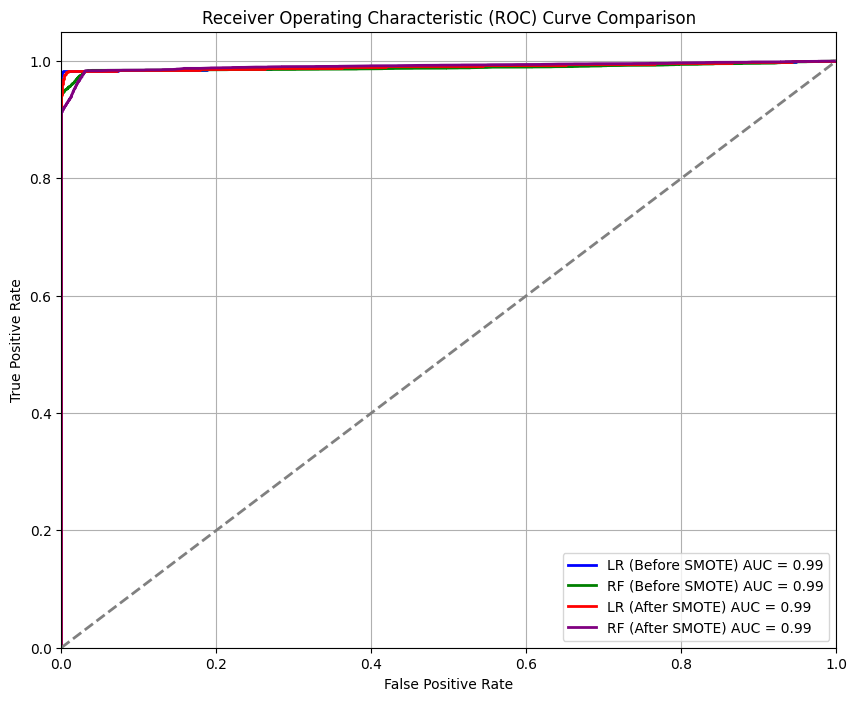

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Function to get probabilities and true labels from Spark DataFrame
def get_roc_data(spark_df, label_col="TX_FRAUD", prob_col="probability"):
    pdf = spark_df.select(label_col, prob_col).toPandas()
    y_true = pdf[label_col].values
    # Extract probability of the positive class (label 1)
    y_proba = pdf[prob_col].apply(lambda x: x[1]).values
    return y_true, y_proba

# Prepare data for plotting ROC curves
lr_y_true, lr_y_proba = get_roc_data(lr_pred)
rf_y_true, rf_y_proba = get_roc_data(rf_pred)
lr_smote_y_true, lr_smote_y_proba = get_roc_data(lr_smote_pred)
rf_smote_y_true, rf_smote_y_proba = get_roc_data(rf_smote_pred)

# Calculate ROC curve and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(lr_y_true, lr_y_proba)
lr_auc = auc(lr_fpr, lr_tpr)

rf_fpr, rf_tpr, _ = roc_curve(rf_y_true, rf_y_proba)
rf_auc_val = auc(rf_fpr, rf_tpr) # Renamed to avoid conflict with existing rf_auc variable

lr_smote_fpr, lr_smote_tpr, _ = roc_curve(lr_smote_y_true, lr_smote_y_proba)
lr_smote_auc_val = auc(lr_smote_fpr, lr_smote_tpr)

rf_smote_fpr, rf_smote_tpr, _ = roc_curve(rf_smote_y_true, rf_smote_y_proba)
rf_smote_auc_val = auc(rf_smote_fpr, rf_smote_tpr)

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, color='blue', lw=2, label=f'LR (Before SMOTE) AUC = {lr_auc:.2f}')
plt.plot(rf_fpr, rf_tpr, color='green', lw=2, label=f'RF (Before SMOTE) AUC = {rf_auc_val:.2f}')
plt.plot(lr_smote_fpr, lr_smote_tpr, color='red', lw=2, label=f'LR (After SMOTE) AUC = {lr_smote_auc_val:.2f}')
plt.plot(rf_smote_fpr, rf_smote_tpr, color='purple', lw=2, label=f'RF (After SMOTE) AUC = {rf_smote_auc_val:.2f}')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Logistic Regression (Before SMOTE)**: Achieved an AUC of 0.9914 and a Recall for the fraud class of 0.9758.
*   **Random Forest (Before SMOTE)**: Achieved an AUC of 0.9888 and a Recall for the fraud class of 0.9426.
*   **Impact of SMOTE on Training Data**: The SMOTE algorithm successfully balanced the training dataset, resulting in an equal number of instances (168,763) for both fraud and non-fraud classes.
*   **Logistic Regression (After SMOTE)**:
    *   The AUC remained high at 0.9914, showing consistent overall discrimination.
    *   The Recall for the fraud class improved to 0.9835, indicating better detection of fraudulent transactions after balancing the training data.
*   **Random Forest (After SMOTE)**:
    *   The AUC increased slightly to 0.9914, demonstrating improved overall performance.
    *   The Recall for the fraud class significantly improved to 0.9750, addressing its lower baseline recall.
*   **Post-SMOTE Model Comparison**: After applying SMOTE, both Logistic Regression and Random Forest models demonstrated excellent and very similar AUC scores (0.9914). Logistic Regression maintained a slight edge in Recall for the fraud class (0.9835) compared to Random Forest (0.9750).

### Insights or Next Steps

*   **SMOTE's Effectiveness**: Applying SMOTE significantly improved the recall for the minority fraud class in both Logistic Regression (from 0.9758 to 0.9835) and Random Forest (from 0.9426 to 0.9750) models, making it a valuable strategy for handling imbalanced datasets in fraud detection.
*   **Model Recommendation**: Given the critical importance of minimizing false negatives in fraud detection, the Logistic Regression model trained with SMOTE-balanced data (Recall: 0.9835) appears to be the marginally preferred choice over Random Forest with SMOTE (Recall: 0.9750) in this scenario.
